In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# data preprocessing
# Resize image size as 54 * 64 and change type to Tensor
# Normalize the data
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# train, validation, test data loading
train_dataset = datasets.ImageFolder(root='./dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='./dataset/val', transform=transform)
test_dataset = datasets.ImageFolder(root='./dataset/test', transform=transform)

#set batch size as 32, shuffle = True
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [62]:
# Make CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*16*16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 11)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*16*16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()


In [65]:
# set criterion as crossentropyloss
# set optimizer as Adam, learning late = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# list that save train and validation accuracy every epoch
train_acc_list = []
val_acc_list = []

#set epoch as 20
epochs = 15

# learning
for epoch in range(epochs): 
    model.train()
    train_correct = 0
    train_total = 0
    run_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    train_acc = 100 * train_correct / train_total
    train_acc_list.append(train_acc)

    # Evaluation
    model.eval()
    val_correct = 0
    val_total = 0

    # For disabling Autograd in PyTorch
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)

    print(f'Epoch {epoch + 1}, Loss: {run_loss / len(train_loader)}, Train Accuracy: {train_acc:.2f}%, Val Accuracy: {val_acc:.2f}%')


Epoch 1, Loss: 1.7507577798178582, Train Accuracy: 31.73%, Val Accuracy: 33.73%
Epoch 2, Loss: 1.4877554207916577, Train Accuracy: 43.00%, Val Accuracy: 40.73%
Epoch 3, Loss: 1.2393136796120292, Train Accuracy: 53.92%, Val Accuracy: 42.36%
Epoch 4, Loss: 0.9800931477447763, Train Accuracy: 64.64%, Val Accuracy: 48.82%
Epoch 5, Loss: 0.6810524301657538, Train Accuracy: 76.16%, Val Accuracy: 48.82%
Epoch 6, Loss: 0.4434697475299796, Train Accuracy: 84.53%, Val Accuracy: 48.91%
Epoch 7, Loss: 0.2069863900387683, Train Accuracy: 93.10%, Val Accuracy: 49.36%
Epoch 8, Loss: 0.1157293451014767, Train Accuracy: 96.64%, Val Accuracy: 51.45%
Epoch 9, Loss: 0.07578752782578382, Train Accuracy: 97.81%, Val Accuracy: 50.64%
Epoch 10, Loss: 0.0641582041401107, Train Accuracy: 98.12%, Val Accuracy: 50.36%
Epoch 11, Loss: 0.057113196718201226, Train Accuracy: 98.55%, Val Accuracy: 46.45%
Epoch 12, Loss: 0.05037271772816592, Train Accuracy: 98.45%, Val Accuracy: 47.27%
Epoch 13, Loss: 0.052815900246044

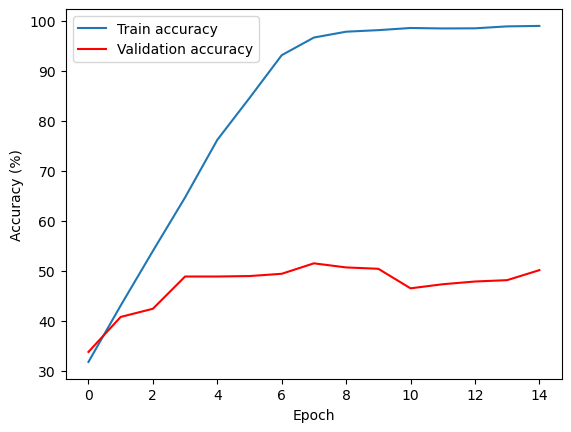

In [66]:
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
from matplotlib import pyplot as plt

#plot train accuracy and validation accuracy for every epoch
x = np.arange(0, epochs)
y1 = [train_acc_list[i]  for i in range(epochs)]
y2 = [val_acc_list[i] for i in range(epochs)]

plt.plot(x, y1 ,label = 'Train accuracy')
plt.plot(x, y2, 'r' ,label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [67]:
#get test accuracy


model.eval()
test_correct = 0
test_total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 60.91%


<AxesSubplot: >

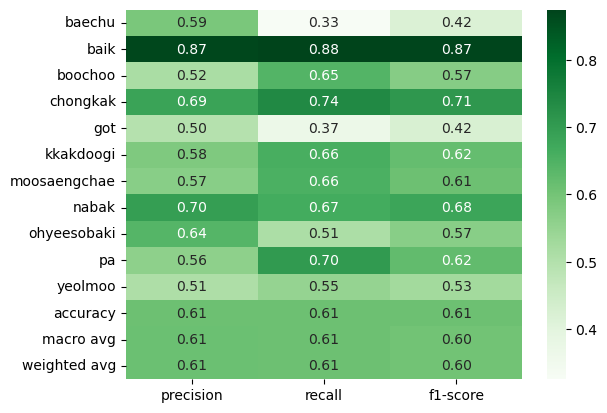

In [69]:
#plot class-wise test accuracy
target_names = ["baechu", "baik", "boochoo", "chongkak", "got", "kkakdoogi", "moosaengchae", "nabak", "ohyeesobaki", "pa", "yeolmoo"]

clf_report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Greens", fmt = '.2f')